In [104]:
import pickle
import matplotlib as mpl

mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['font.family']      = 'Arial'

In [2]:
# SUBFUNCTIONS

def merge_capacity_data(results_dict):
    '''Returns a dataframe with merged capacity data based on a dictionary containing a set of results class
    '''
    # init blank df
    capacities = pd.DataFrame()
    # loop results 
    for k in results_dict.keys():
        df = results_dict[k].results_capacities
        capacities = capacities.append(df,ignore_index=True)
    return capacities


def get_relative_capacities(results_dict):
    capacities = merge_capacity_data(results_dict)
    # get bas and delta dfs
    bas   = capacities.loc[capacities.scenario.isin(['BAS'])].reset_index(drop=True)
    delta = capacities.loc[~capacities.scenario.isin(['BAS'])].reset_index(drop=True)
    # group
    bas   = bas.groupby(by=['scenario','technology','territory']).max().reset_index()
    delta = delta.groupby(by=['scenario','technology','territory']).max().reset_index()
    # map baseline capacities
    bas = bas.set_index('node')['value'].to_dict()
    delta['bas_cap'] = delta.node.map(bas)
    # compute delta
    delta['relative_change'] = delta['value'] - delta['bas_cap']
    return delta


def merge_cost_data(results_dict):
    '''Returns a dataframe with merged capacity data based on a dictionary containing a set of results class
    '''
    # init blank df
    costs = pd.DataFrame()
    # loop results 
    for k in results_dict.keys():
        df = results_dict[k].results_costs
        costs = costs.append(df,ignore_index=True)
    return costs


def export_results_for_chord(merged_results,scenario):
    '''Export a csv for chord plots
    '''
    df = merged_results[scenario].results_edge_flows.copy()

    df['from_territory'] = ''
    df['to_territory'] = ''
    df = df[df.from_id.str.contains('generation')].reset_index(drop=True)

    df.loc[df.from_id.str.contains('israel'),'from_territory'] = 'ISR'
    df.loc[df.from_id.str.contains('west_bank'),'from_territory'] = 'WBK'
    df.loc[df.from_id.str.contains('gaza'),'from_territory'] = 'GZA'
    df.loc[df.from_id.str.contains('jordan'),'from_territory'] = 'JOR'
    df.loc[df.from_id.str.contains('egypt'),'from_territory'] = 'EGY'

    df.loc[df.to_id.str.contains('israel'),'to_territory'] = 'ISR'
    df.loc[df.to_id.str.contains('west_bank'),'to_territory'] = 'WBK'
    df.loc[df.to_id.str.contains('gaza'),'to_territory'] = 'GZA'
    df.loc[df.to_id.str.contains('jordan'),'to_territory'] = 'JOR'
    df.loc[df.to_id.str.contains('egypt'),'to_territory'] = 'EGY'
    
    df = df[['from_territory','to_territory','value']]
    df = df.groupby(by=['from_territory','to_territory']).sum().reset_index()
    
    # units?
    df.value = df.value.divide(10**3)
    # save
    df.to_csv('plots/chord_data/' + scenario + '.csv',index=False)
    print('done.')

export_results_for_chord(results,scenario='BAU')
export_results_for_chord(results,scenario='NCO')
export_results_for_chord(results,scenario='EAG')
export_results_for_chord(results,scenario='COO')
export_results_for_chord(results,scenario='UTO')

## Load scenario results

In [ ]:
file = open('../outputs/model_run_results.pkl','rb')
results = pickle.load(file)
file.close()

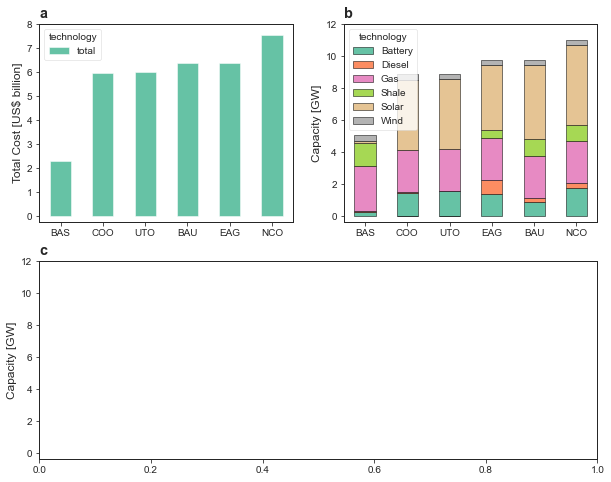

In [212]:
hls_colours = sns.color_palette("Set2", as_cmap=True)

costs = merge_cost_data(results)

costs = costs.pivot_table(index=['scenario'],
                          columns=['technology'],
                          values='totex')

costs['total'] = costs.sum(axis=1)
costs = costs.reset_index(drop=False)
costs = costs[['scenario','total']]
costs = costs.sort_values('total')
costs['total'] = costs['total'].divide(10**9)

# run function
capacities = merge_capacity_data(results)
# convert to gw
#capacities['value'] = capacities['value'].apply(lambda row: mw_to_gw(row))
# pivot for bar chart
capacities = capacities.pivot_table(index=['scenario'],
                                    columns=['technology'],
                                    values='value')
# sort by ascending
capacities['total'] = capacities.sum(axis=1)
capacities = capacities.sort_values("total").drop('total',axis=1)
capacities = capacities.drop(['Coal','Gas Reservoir'],axis=1)





plt.figure(figsize=(10, 8))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,1,2)

sns.set_style("ticks")
costs.set_index('scenario').plot.bar(ax=ax1,color=hls_colours.colors[0],rot=0)
ax1.set_xlabel('')
ax1.set_ylabel('Total Cost [US$ billion]')
ax1.set_ylim([-8*0.03,8])
ax1.set_title('a',fontweight='bold',loc='left')

capacities.divide(1000).plot.bar(stacked=True,rot=0,ax=ax2,
                                 cmap=hls_colours,edgecolor='black')

ax2.set_xlabel('')
ax2.set_ylabel('Capacity [GW]')
ax2.set_title('b',fontweight='bold',loc='left')
ax2.set_ylim([-12*0.03,12])


ax3.set_xlabel('')
ax3.set_ylabel('Capacity [GW]')
ax3.set_title('c',fontweight='bold',loc='left')
ax3.set_ylim([-12*0.03,12])

f.savefig('../outputs/figures/scenario_analysis.pdf',bbox_inches='tight')

## Plot: summary of scenario analysis

This figure shows: 

    a. Total cost ($) by scenario
    b. Total capacity (GW) by scenario and technology
    c. Summary of various variables by scenario (e.g., NOx, SOx etc.)

(0.0, 30.0)

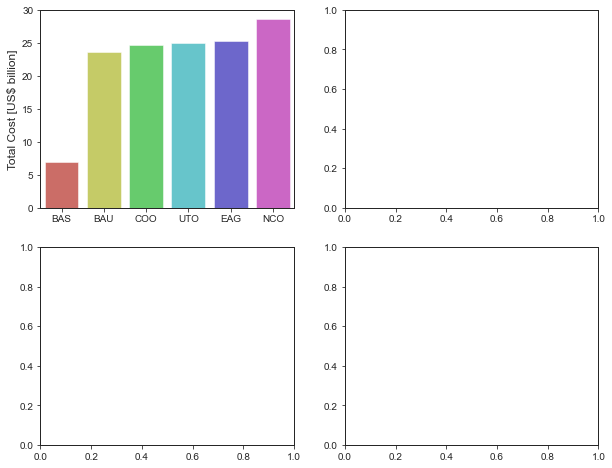

In [105]:
costs = merge_cost_data(results)
costs = costs.groupby(by='scenario').sum().reset_index()
costs = costs.sort_values('totex')
costs['totex'] = costs['totex'].divide(10**9)

f,ax = plt.subplots(figsize=(10,8),nrows=2,ncols=2)

sns.set_style("ticks")
sns.barplot(x='scenario',y='totex',data=costs,ax=ax[0,0],palette='hls')
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Total Cost [US$ billion]')
ax[0,0].set_ylim([0,30])

In [52]:
results

{'BAS': <infrasim.postprocess.nextra_postprocess at 0x18f5c8dc0>,
 'BAU': <infrasim.postprocess.nextra_postprocess at 0x18da3cfa0>,
 'NCO': <infrasim.postprocess.nextra_postprocess at 0x18c1e41c0>,
 'EAG': <infrasim.postprocess.nextra_postprocess at 0x18a984eb0>,
 'COO': <infrasim.postprocess.nextra_postprocess at 0x18906ee50>,
 'UTO': <infrasim.postprocess.nextra_postprocess at 0x187691df0>}

## Create costs figure
This figure will show the required costs ($) in 2030 per scenario as a bar chart

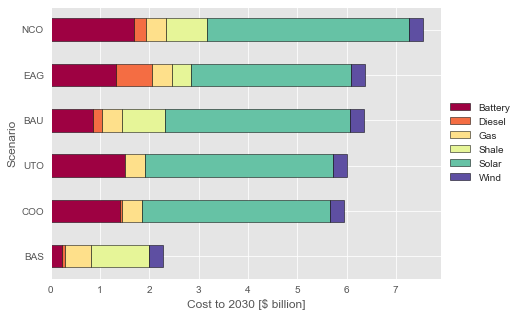

In [89]:
# run function
costs = merge_cost_data(results)
# convert to gw
#capacities['value'] = capacities['value'].apply(lambda row: mw_to_gw(row))
# pivot for bar chart
costs = costs.pivot_table(index=['scenario'],
                          columns=['technology'],
                          values='totex')
# sort by ascending
costs['total'] = costs.sum(axis=1)
costs = costs.sort_values("total").drop('total',axis=1)

# convert to billion
costs = costs.mul(10**-9)

costs = costs.drop(['Coal'],axis=1)

# plot
plt.style.use('ggplot')
f,ax = plt.subplots(ncols=1,nrows=1,figsize=(7,5))
costs.plot.barh(stacked=True,rot=0,ax=ax,cmap='Spectral',edgecolor='black')
ax.set_xlabel('Cost to 2030 [$ billion]')
ax.set_ylabel('Scenario')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),frameon=False)
f.savefig('../outputs/figures/totex_by_scenario.pdf',bbox_inches='tight',edgecolor='black')

## Create capacities figure
This figure will show the required capacity (GW) in 2030 per scenario as a bar chart

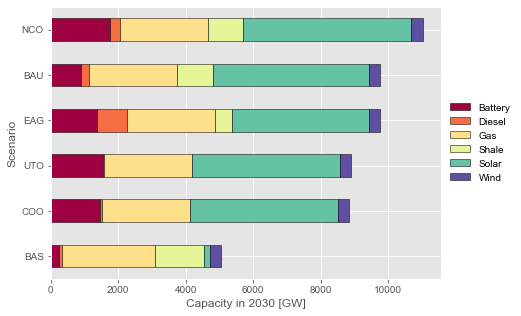

In [11]:
# run function
capacities = merge_capacity_data(results)
# convert to gw
#capacities['value'] = capacities['value'].apply(lambda row: mw_to_gw(row))
# pivot for bar chart
capacities = capacities.pivot_table(index=['scenario'],
                                    columns=['technology'],
                                    values='value')
# sort by ascending
capacities['total'] = capacities.sum(axis=1)
capacities = capacities.sort_values("total").drop('total',axis=1)
capacities = capacities.drop(['Coal','Gas Reservoir'],axis=1)

# plot
plt.style.use('ggplot')
f,ax = plt.subplots(ncols=1,nrows=1,figsize=(7,5))
capacities.plot.barh(stacked=True,rot=0,ax=ax,cmap='Spectral',edgecolor='black')
ax.set_xlabel('Capacity in 2030 [GW]')
ax.set_ylabel('Scenario')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),frameon=False)
f.savefig('../outputs/figures/capacity_by_scenario.pdf',bbox_inches='tight')

## Relative capacity change
This figure shows the capacity change (GW) per scenario relative to BAS

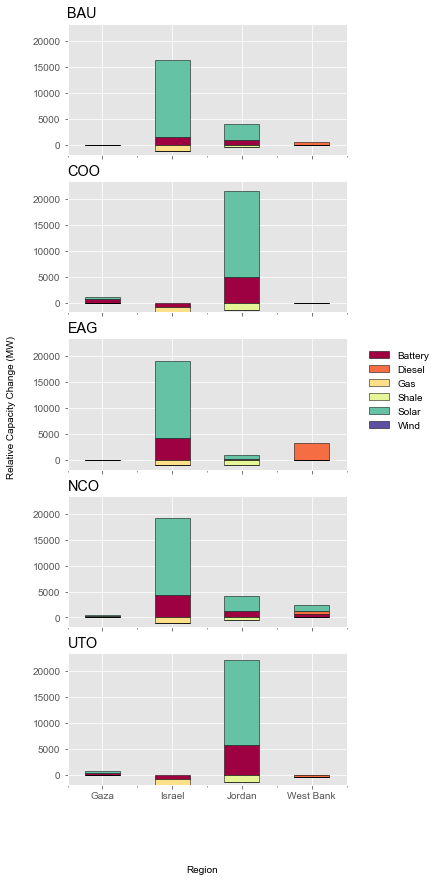

In [12]:
delta = get_relative_capacities(results)
delta = delta[~delta.technology.isin(['Gas Reservoir','Coal'])].reset_index(drop=True)

f,ax = plt.subplots(ncols=1,nrows=5,figsize=(5,14),sharex=True,sharey=True)

count=0
for s in delta.scenario.unique():
    idx = delta.loc[delta.scenario.isin([s])]
    idx = idx.pivot_table(index=['territory'],columns=['technology'],values='relative_change')
    idx.plot.bar(stacked=True,rot=0,ax=ax[count],cmap='Spectral',edgecolor='black',legend=False)
    #ax[count].set_ylim([-5000,20000])
    ax[count].set_xlabel(None)
    ax[count].set_title(s,loc='left')
    count=count+1

plt.legend(loc='center left', bbox_to_anchor=(1.05, 3),frameon=False)

f.text(0.5, 0.04, 'Region', ha='center', va='center')
f.text(-0.03, 0.5, 'Relative Capacity Change (MW)', ha='center', va='center', rotation='vertical')

f.savefig('../outputs/figures/relative_capacity_by_scenario.pdf',bbox_inches='tight')

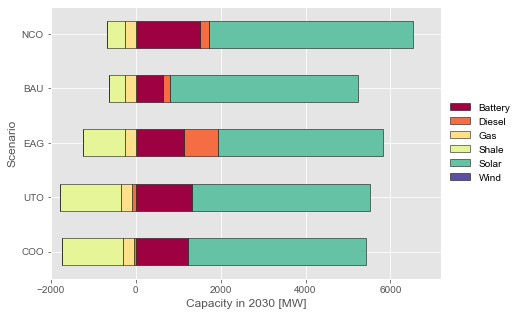

In [13]:
# plot
delta = get_relative_capacities(results)
plt.style.use('ggplot')
f,ax = plt.subplots(ncols=1,nrows=1,figsize=(7,5))
delta = delta.pivot_table(index=['scenario'],columns=['technology'],values='relative_change')
delta = delta.drop(['Coal','Gas Reservoir'],axis=1)
# sort by ascending
delta['total'] = delta.sum(axis=1)
delta = delta.sort_values("total").drop('total',axis=1)
delta.plot.barh(stacked=True,rot=0,ax=ax,cmap='Spectral',edgecolor='black')
ax.set_xlabel('Capacity in 2030 [MW]')
ax.set_ylabel('Scenario')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),frameon=False)
ax.set_xlim([-2000,7200])
f.savefig('../outputs/figures/relative_capacity_by_scenario_2.pdf',bbox_inches='tight')

## Emissions by scenario
Create a boxplot of emissions (y-axis) by scenario (x-axis)

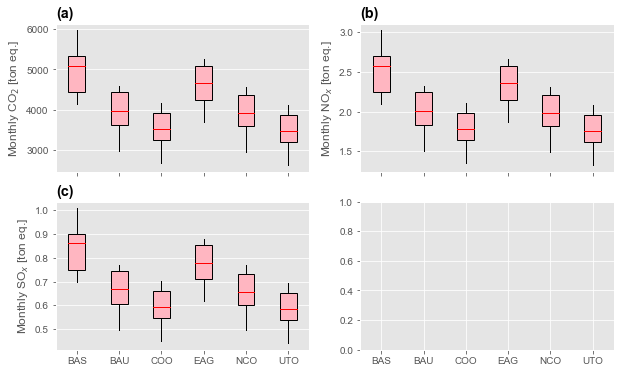

In [14]:
def map_territory(df,on):
    '''Map territory onto dataframe
    '''
    # add regions
    df['territory'] = np.nan
    df.loc[df[on].str.contains('jordan'),'territory']  = 'Jordan'
    df.loc[df[on].str.contains('israel'),'territory']  = 'Israel'
    df.loc[df[on].str.contains('west'),'territory']    = 'West Bank'
    df.loc[df[on].str.contains('gaza'),'territory']    = 'Gaza'
    df.loc[df[on].str.contains('super'),'territory']   = 'Shortage'
    df.loc[df[on].str.contains('egypt'),'territory']   = 'Egypt'
    return df


def map_technology(df,on):
    '''Map technology onto dataframe
    '''
    df['technology'] = np.nan
    df.loc[df.from_id.str.contains('solar'),'technology']       = 'Solar'
    df.loc[df.from_id.str.contains('coal'),'technology']        = 'Coal'
    df.loc[df.from_id.str.contains('diesel'),'technology']      = 'Diesel'
    df.loc[df.from_id.str.contains('ccgt'),'technology']        = 'Gas'
    df.loc[df.from_id.str.contains('gas'),'technology']         = 'Gas'
    df.loc[df.from_id.str.contains('shale'),'technology']       = 'Shale'
    df.loc[df.from_id.str.contains('wind'),'technology']        = 'Wind'
    df.loc[df.from_id.str.contains('storage'),'technology']     = 'Storage'
    df.loc[df.from_id.str.contains('super'),'technology']       = 'Shortage'
    return df


def map_sox_emissions(df,on):
    '''
    '''
    df['sox'] = df[on] * df['technology'].map(sox)
    return df


def map_nox_emissions(df,on):
    '''
    '''
    df['nox'] = df[on] * df['technology'].map(nox)
    return df


def map_co2_emissions(df,on):
    '''
    '''
    df['co2'] = df[on] * df['technology'].map(co2)
    return df


merged_flows = pd.DataFrame()
for k in results.keys():
    sn = get_source_nodes(results[k].nodes).name.to_list()
    df = results[k].results_edge_flows.loc[results[k].results_edge_flows.from_id.isin(sn)]
    df = df.drop(['to_id','commodity','timestep','hour'],axis=1)
    df = df.groupby(by=['from_id','day','month','year','scenario']).sum().reset_index()
    df = map_territory(df,on='from_id')
    df = map_technology(df,on='from_id')
    merged_flows = merged_flows.append(df,ignore_index=True)

merged_flows = map_sox_emissions(merged_flows,on='value')
merged_flows = map_nox_emissions(merged_flows,on='value')
merged_flows = map_co2_emissions(merged_flows,on='value')

merged_flows = merged_flows.groupby(by=['month','year','scenario']).sum().reset_index()

# adjust units
merged_flows['co2'] = merged_flows['co2'].divide(10**6)
merged_flows['nox'] = merged_flows['nox'].divide(10**6)
merged_flows['sox'] = merged_flows['sox'].divide(10**6)

props = {'boxprops':{'facecolor':'lightpink', 'edgecolor':'black','linewidth':1},
         'medianprops':{'color':'red','linewidth':1},
         'whiskerprops':{'color':'black','linewidth':1},
         'capprops':{'color':'none'}}

f,ax = plt.subplots(nrows=2,ncols=2,figsize=(10,6),sharex=True)

sns.boxplot(x='scenario',y='co2',data=merged_flows,showfliers=False,
            ax=ax[0,0],width=0.4,**props)

sns.boxplot(x='scenario',y='nox',data=merged_flows,showfliers=False,
            ax=ax[0,1],width=0.4,**props)

sns.boxplot(x='scenario',y='sox',data=merged_flows,showfliers=False,
            ax=ax[1,0],width=0.4,**props)

ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[1,0].set_xlabel('')

ax[0,0].set_title('(a)',loc='left',fontweight='bold')
ax[0,1].set_title('(b)',loc='left',fontweight='bold')
ax[1,0].set_title('(c)',loc='left',fontweight='bold')

ax[0,0].set_ylabel('Monthly CO$_2$ [ton eq.]')
ax[0,1].set_ylabel('Monthly NO$_x$ [ton eq.]')
ax[1,0].set_ylabel('Monthly SO$_x$ [ton eq.]')

f.savefig('../outputs/figures/emissions_boxplot.pdf',bbox_inches='tight')

## Plotting winter/summer curves


## Self-sufficiency vs cooperation
Here I'll analyse the relationship between self-sufficiency and cooperation in the context of the Palestinian Authority. 

In [15]:
# #File paths
# nodes = '../data/nextra/spatial/network/nodes.shp'
# edges = '../data/nextra/spatial/network/edges.shp'
# flows = '../data/nextra/nodal_flows/processed_flows_2030.csv'

# # Params
# timesteps=None#7000
# super_source=False
# pprint=True
# save_figures=True

# infrasim_init_directories()

# ss_factors = [i/100 for i in np.arange(0,101,5).tolist()]

# results = {}
# for s in ss_factors:
    
#     model_run = nextra(nodes,edges,flows,
#                        scenario='COO',
#                        energy_objective=True,
#                        timesteps=timesteps,
#                        self_sufficiency_factor=s)

#     model_run.build()
#     model_run.run(pprint=False)
#     try:
#         model_results = model_run.get_results()
#         # add scenarios to results
#         if s == 'BAU' and scenarios[s] == False:
#             s = 'BAS'
#         model_results.results_capacities['self_sufficiency_factor']       = s
#         model_results.results_storages['self_sufficiency_factor']         = s
#         model_results.results_edge_flows['self_sufficiency_factor']       = s
#         model_results.results_capacity_change['self_sufficiency_factor']  = s
#         model_results.results_costs['self_sufficiency_factor']            = s
#         # append results
#         results[ 'COO_' + str(s) ] = model_results
#         print('> Completed: ' + str(s))
#     except:
#         print('> FAILED! ' + str(s))
#         os.system('say "Scenario failed"')

# capacities = merge_capacity_data(results)
# capacities = capacities.groupby(by=['territory','self_sufficiency_factor','node']).max().reset_index()
# capacities = capacities.loc[capacities.territory.isin(['Gaza','West Bank'])].reset_index(drop=True)
# capacities = capacities.groupby(by=['territory','self_sufficiency_factor']).sum().reset_index()
# capacities = capacities.loc[capacities.value>0]
# capacities = capacities.groupby(by='self_sufficiency_factor').sum().reset_index()

# f,ax = plt.subplots(nrows=1,ncols=1,figsize=(5.5,5))

# sns.set_theme()

# sns.lineplot(x='self_sufficiency_factor',
#              y='value',
#              #hue='node',
#              ax=ax,
#              data=capacities)

# plt.xlabel('Self-sufficiency [%]')
# plt.ylabel('Total capacity added [MW]')
# plt.title('Capacity in West Bank and Gaza',loc='left',fontweight='bold')
# plt.xlim([0,0.9])
# f.savefig('../outputs/figures/coop_tradeoff.pdf',bbox_inches='tight')

In [16]:
# capacities = merge_capacity_data(results)
# capacities = capacities.groupby(by=['territory','self_sufficiency_factor','node']).max().reset_index()
# capacities = capacities.loc[capacities.territory.isin(['Gaza','West Bank'])].reset_index(drop=True)
# capacities = capacities.groupby(by=['self_sufficiency_factor']).sum().reset_index()
# #capacities = capacities.loc[capacities.value>0]
# # capacities = capacities.groupby(by='self_sufficiency_factor').sum().reset_index()

# capacities

In [17]:
# def fitted_curve(x,y,df,scatter=True,label='fitted'):
#     x = df[x].to_numpy()
#     y = df[y].to_numpy()
#     # calculate polynomial
#     z = np.polyfit(x, y, 1)
#     f = np.poly1d(z)
#     # calculate new x's and y's
#     x_new = np.linspace(x[0], x[-1], 50)
#     y_new = f(x_new)
#     # plot
#     if not scatter:
#         plt.plot(x_new, y_new,label=label)
#     else:
#         plt.plot(x,y,'o')
#         plt.plot(x_new, y_new,label=label)


# plt.figure(figsize=(5,4.5))

# fitted_curve(x='self_sufficiency_factor',y='value',scatter=True,df=capacities)

# # fitted_curve(x='self_sufficiency_factor',y='value',scatter=True,
# #              df=capacities[capacities.territory=='Gaza'],label='Gaza')

# # fitted_curve(x='self_sufficiency_factor',y='value',scatter=True,
# #              df=capacities[capacities.territory=='West Bank'],label='West Bank')

# plt.legend()

In [18]:
# #File paths
# nodes = '../data/nextra/spatial/network/nodes.shp'
# edges = '../data/nextra/spatial/network/edges.shp'
# flows = '../data/nextra/nodal_flows/processed_flows_2030.csv'

# # Params
# timesteps=24#7000
# super_source=False
# pprint=True
# save_figures=True

# infrasim_init_directories()

# scenarios = {
#              'COO' : True,
#             }

# results = {}
# for s in scenarios:
        
#     model_run = nextra(nodes,edges,flows,
#                        scenario=s,
#                        energy_objective=scenarios[s],
#                        timesteps=timesteps,
#                        israel_to_westbank=0,
#                        jordan_to_westbank=0,
#                        israel_to_gaza=0,
#                        #super_source=True,
#                        #super_sink=True,
#                        #res_factor=99,
#                        #model_name='meow',
#                       )

#     model_run.build()
#     model_run.run(pprint=False)
#     try:
#         model_results = model_run.get_results()
#         # add scenarios to results
#         if s == 'BAU' and scenarios[s] == False:
#             s = 'BAS'
#         model_results.results_capacities['scenario']       = s
#         model_results.results_storages['scenario']         = s
#         model_results.results_edge_flows['scenario']       = s
#         model_results.results_capacity_change['scenario']  = s
#         model_results.results_costs['scenario']            = s
#         # append results
#         results[s] = model_results
#         print('> Completed: ' + s)
#     except:
#         print('> FAILED! ' + s)

# results['COO'].plot_flows_sankey(height=500,title='COO')

## Visualise flows
This figure visualises flows between each territory

###### NOTE TO SELF:
Here I'm trying to generate a set of sankey plots in a loop (currently testing just for NCO) but can't get the plotly figure to save... getting the error:

> The colour should be an integer rather than string... maybe?
> When colour arguments are commented out, I get the following error: 01 The kaleido executable is required by the kaleido Python library, but it was not included

In [19]:
# import os
# import seaborn as sns
# import matplotlib.pyplot as plt

# import warnings
# warnings.filterwarnings('ignore')

# import sys
# sys.path.append('../')

# from infrasim.optimise import *
# from infrasim.utils import *

# # SUBFUNCTIONS
# def merge_capacity_data(results_dict):
#     '''Returns a dataframe with merged capacity data based on a dictionary containing a set of results class
#     '''
#     # init blank df
#     capacities = pd.DataFrame()
#     # loop results 
#     for k in results_dict.keys():
#         df = results_dict[k].results_capacities
#         capacities = capacities.append(df,ignore_index=True)
#     return capacities


# def get_relative_capacities(results_dict):
#     capacities = merge_capacity_data(results_dict)
#     # get bas and delta dfs
#     bas   = capacities.loc[capacities.scenario.isin(['BAS'])].reset_index(drop=True)
#     delta = capacities.loc[~capacities.scenario.isin(['BAS'])].reset_index(drop=True)
#     # group
#     bas   = bas.groupby(by=['scenario','technology','territory']).max().reset_index()
#     delta = delta.groupby(by=['scenario','technology','territory']).max().reset_index()
#     # map baseline capacities
#     bas = bas.set_index('node')['value'].to_dict()
#     delta['bas_cap'] = delta.node.map(bas)
#     # compute delta
#     delta['relative_change'] = delta['value'] - delta['bas_cap']
#     return delta

# #File paths
# nodes = '../data/nextra/spatial/network/nodes.shp'
# edges = '../data/nextra/spatial/network/edges.shp'
# flows = '../data/nextra/nodal_flows/processed_flows_2030.csv'

# # Params
# timesteps=24#7000
# super_source=False
# pprint=True
# save_figures=True

# infrasim_init_directories()

# scenarios = {
#              'NCO' : True,
#             }

# results = {}
# for s in scenarios:
        
#     model_run = nextra(nodes,edges,flows,
#                        scenario=s,
#                        energy_objective=scenarios[s],
#                        timesteps=timesteps,
#                        #super_source=True,
#                        #super_sink=True,
#                        #res_factor=99,
#                        #model_name='meow',
#                       )

#     model_run.build()
#     model_run.run(pprint=False)
#     try:
#         model_results = model_run.get_results()
#         # add scenarios to results
#         if s == 'BAU' and scenarios[s] == False:
#             s = 'BAS'
#         model_results.results_capacities['scenario']       = s
#         model_results.results_storages['scenario']         = s
#         model_results.results_edge_flows['scenario']       = s
#         model_results.results_capacity_change['scenario']  = s
#         model_results.results_costs['scenario']            = s
#         # append results
#         results[s] = model_results
#         print('> Completed: ' + s)
#     except:
#         print('> FAILED! ' + s)
#         os.system('say "Scenario failed"')

# #os.system('say "Code block finished"')

# print('> Done.')

# results['NCO'].plot_flows_sankey(height=500,title='No Cooperation')